In [1]:
import numpy as np
import pandas as pd 

In [2]:
import mat73

from tqdm import tqdm

def load_mat_file(file_path):
    data_dict = mat73.loadmat(file_path, only_include=['Subset/Signals'])

    array_3d = data_dict['Subset']['Signals']

    reshaped = [[list(row[col]) for col in range(array_3d.shape[1])] for row in array_3d]

    signals_df = pd.DataFrame(reshaped, columns = ['ECG', 'PPG', 'ABP'])

    df = pd.DataFrame.from_dict({k: v for (k, v) in data_dict['Subset'].items() if k != 'Signals'})  

    df['Subject'] = df['Subject'].apply(lambda x: x[0])

    data_df = pd.concat([df, signals_df], axis=1)
    
    return data_df

In [3]:
file_path = './VitalDB_AAMI_Test_Subset.mat'
tr_file_path = './VitalDB_Train_Subset.mat'

In [4]:
test = mat73.loadmat(file_path)

In [ ]:
# Before we meet can you review the Objective I have, it is to create model that uses ECG, PPG and other signals to predict ABP 
# signal or mean ABP on each time window of 7-10s.
# Can you take a look on the data and let me know how much time you will need to achieve MAE of 7-8?

In [5]:
test['Subset'].keys()

dict_keys(['Age', 'BMI', 'DBP', 'Gender', 'Height', 'SBP', 'Signals', 'Subject', 'Weight'])

In [8]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
import matplotlib.pyplot as plt

series = []
val_series = []
ecg = []
val_ecg = []
ppg = []
val_ppg = []

scaler_series = Scaler()
scaler_ecg = Scaler()
scaler_ppg = Scaler()

for signal in test['Subset']['Signals'][:1]:
    df = pd.DataFrame(signal.T, columns  = ['ECG', 'PPG', 'ABP'])\
        .reset_index().rename(columns = {'index': 'date', 'ABP': 'value'})

    s = TimeSeries.from_dataframe(df, 'date', 'value')
    train_s, val_s = s[:int(len(s)*0.8)], s[int(len(s)*0.8):]

    series.append(scaler_series.fit_transform(train_s))
    val_series.append(scaler_series.transform(val_s))

    e = TimeSeries.from_dataframe(df, 'date', 'ECG')
    train_e, val_e = e[:int(len(e)*0.8)], e[int(len(e)*0.8):]

    ecg.append(scaler_ecg.fit_transform(train_e))
    val_ecg.append(scaler_ecg.transform(val_e))

    p = TimeSeries.from_dataframe(df, 'date', 'PPG')
    train_p, val_p = p[:int(len(p)*0.8)], p[int(len(p)*0.8):]

    ppg.append(scaler_ppg.fit_transform(train_p))
    val_ppg.append(scaler_ppg.transform(val_p))

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [17]:
ecg.stack

AttributeError: 'list' object has no attribute 'stack'

In [13]:
import torch
from darts.models import NBEATSModel

from darts import concatenate

model = NBEATSModel(
    input_chunk_length=128,
    output_chunk_length=60,
    random_state=42,
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-3},
    n_epochs=20,
    num_stacks=2,
    num_layers=3,
)

model.fit(
    series=series,
    val_series=val_series, 
    past_covariates=concatenate([ecg, ppg]),
    val_past_covariates=concatenate([val_ecg, val_ppg]),
    verbose=True
)

AttributeError: 'list' object has no attribute 'time_dim'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

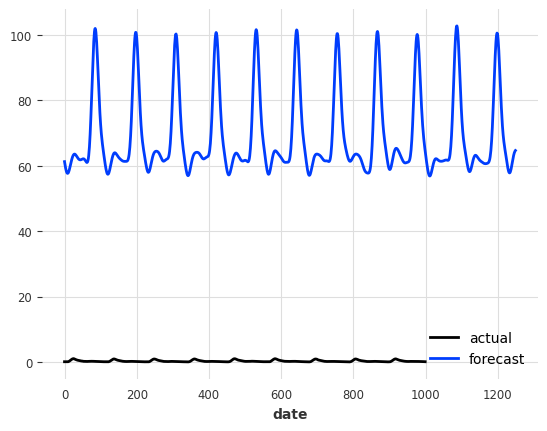

Mean Absolute Percentage Error: 99.53%


In [10]:
prediction = model.predict(
    n=6,
    series=series,
    past_covariates=ecg,
)

for i, x in enumerate(prediction[:5]):
    prediction_descaled = scaler_series.inverse_transform(p)

    series[i].plot(label='actual')
    prediction_descaled.plot(label='forecast', lw=2)
    plt.legend()
    plt.show()

    error = mape(prediction_descaled, val_series[i])
    print(f"Mean Absolute Percentage Error: {error:.2f}%")